In [1]:
import os
import torch
import torch.optim as optim

from torchvision.ops import complete_box_iou_loss
from tqdm import tqdm

from architectures.bigger_basic import BoundingBoxModel
from functions.datasets import get_loaders
from functions.loop_management import EarlyStopping
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [3]:
RUN_NUMBER = 0
dataset, train_loader, valid_loader = get_loaders(
    os.path.join("data", "train_images"),
    os.path.join("data", "train_coco_annotations.json"),
    prefetch_factor=16
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
cuda


In [4]:
model = BoundingBoxModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 25
epochs_used = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        ciou_loss = complete_box_iou_loss(outputs, bboxes)
        loss = ciou_loss.mean()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")

    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            ciou_loss = complete_box_iou_loss(outputs, bboxes)
            loss = ciou_loss.mean()
            val_loss += loss.item()

            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    epochs_used += 1

    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

    early_stopping(
        epoch_val_loss, 
        model, 
        path=os.path.join("checkpoints", f"checkpoint_3_1_bigger_basic_ciou_run_{RUN_NUMBER}.pt")
    )

    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete")

Epoch 1/25 - Training: 100%|██████████| 227/227 [00:16<00:00, 14.13it/s, Train Loss=0.579]


Epoch 1, Loss: 0.5790968710630475


Epoch 1/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.04it/s, Val Loss=0.409]


Validation Loss: 0.40890623359953254
Validation loss decreased (inf --> 0.408906).  Saving model ...


Epoch 2/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.84it/s, Train Loss=0.369]


Epoch 2, Loss: 0.3692164062665948


Epoch 2/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.84it/s, Val Loss=0.35] 


Validation Loss: 0.3502388639859691
Validation loss decreased (0.408906 --> 0.350239).  Saving model ...


Epoch 3/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.80it/s, Train Loss=0.323]


Epoch 3, Loss: 0.3228287275404657


Epoch 3/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.96it/s, Val Loss=0.312]


Validation Loss: 0.3122855601463024
Validation loss decreased (0.350239 --> 0.312286).  Saving model ...


Epoch 4/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.40it/s, Train Loss=0.303]


Epoch 4, Loss: 0.30265395106985704


Epoch 4/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.06it/s, Val Loss=0.342]


Validation Loss: 0.34218618194962386
EarlyStopping counter: 1 out of 7


Epoch 5/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.53it/s, Train Loss=0.293]


Epoch 5, Loss: 0.2926489856537218


Epoch 5/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 17.35it/s, Val Loss=0.339]


Validation Loss: 0.3389869677600356
EarlyStopping counter: 2 out of 7


Epoch 6/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.73it/s, Train Loss=0.291]


Epoch 6, Loss: 0.2906750211500386


Epoch 6/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.11it/s, Val Loss=0.313]


Validation Loss: 0.3128459891427456
EarlyStopping counter: 3 out of 7


Epoch 7/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.82it/s, Train Loss=0.281]


Epoch 7, Loss: 0.28066582623294795


Epoch 7/25 - Validation: 100%|██████████| 227/227 [00:14<00:00, 15.61it/s, Val Loss=0.264]


Validation Loss: 0.2638974389972141
Validation loss decreased (0.312286 --> 0.263897).  Saving model ...


Epoch 8/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.60it/s, Train Loss=0.278]


Epoch 8, Loss: 0.27754078030848817


Epoch 8/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.97it/s, Val Loss=0.272]


Validation Loss: 0.2719965592880081
EarlyStopping counter: 1 out of 7


Epoch 9/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.74it/s, Train Loss=0.272]


Epoch 9, Loss: 0.27195901538569495


Epoch 9/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.99it/s, Val Loss=0.251]


Validation Loss: 0.25118519543025986
Validation loss decreased (0.263897 --> 0.251185).  Saving model ...


Epoch 10/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.52it/s, Train Loss=0.263]


Epoch 10, Loss: 0.2627522371020086


Epoch 10/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.93it/s, Val Loss=0.29] 


Validation Loss: 0.2902538232209924
EarlyStopping counter: 1 out of 7


Epoch 11/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.92it/s, Train Loss=0.258]


Epoch 11, Loss: 0.2575500131572396


Epoch 11/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.89it/s, Val Loss=0.249]


Validation Loss: 0.2487067578910206
Validation loss decreased (0.251185 --> 0.248707).  Saving model ...


Epoch 12/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.59it/s, Train Loss=0.26] 


Epoch 12, Loss: 0.2602517080333264


Epoch 12/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.97it/s, Val Loss=0.366]


Validation Loss: 0.36600606123781415
EarlyStopping counter: 1 out of 7


Epoch 13/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.74it/s, Train Loss=0.26] 


Epoch 13, Loss: 0.25957272434812284


Epoch 13/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.33it/s, Val Loss=0.246]


Validation Loss: 0.24632152993773573
Validation loss decreased (0.248707 --> 0.246322).  Saving model ...


Epoch 14/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.74it/s, Train Loss=0.252]


Epoch 14, Loss: 0.25219597230923857


Epoch 14/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.87it/s, Val Loss=0.233]


Validation Loss: 0.23330689264289084
Validation loss decreased (0.246322 --> 0.233307).  Saving model ...


Epoch 15/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.57it/s, Train Loss=0.245]


Epoch 15, Loss: 0.24491123710697443


Epoch 15/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.87it/s, Val Loss=0.286]


Validation Loss: 0.2860315883212153
EarlyStopping counter: 1 out of 7


Epoch 16/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.63it/s, Train Loss=0.248]


Epoch 16, Loss: 0.247971650853031


Epoch 16/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.90it/s, Val Loss=0.238]


Validation Loss: 0.23755478878640918
EarlyStopping counter: 2 out of 7


Epoch 17/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.65it/s, Train Loss=0.238]


Epoch 17, Loss: 0.23768064924536297


Epoch 17/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.40it/s, Val Loss=0.247]


Validation Loss: 0.24724724206105203
EarlyStopping counter: 3 out of 7


Epoch 18/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.74it/s, Train Loss=0.235] 


Epoch 18, Loss: 0.23463164565321631


Epoch 18/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.81it/s, Val Loss=0.226]


Validation Loss: 0.22572542490675587
Validation loss decreased (0.233307 --> 0.225725).  Saving model ...


Epoch 19/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.50it/s, Train Loss=0.23]  


Epoch 19, Loss: 0.2297749279091537


Epoch 19/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.88it/s, Val Loss=0.248]


Validation Loss: 0.2482671121931286
EarlyStopping counter: 1 out of 7


Epoch 20/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.47it/s, Train Loss=0.236]


Epoch 20, Loss: 0.23625882902071865


Epoch 20/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.28it/s, Val Loss=0.248]


Validation Loss: 0.24815002077213993
EarlyStopping counter: 2 out of 7


Epoch 21/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.92it/s, Train Loss=0.225]


Epoch 21, Loss: 0.2246379539830044


Epoch 21/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.42it/s, Val Loss=0.233]


Validation Loss: 0.23256555088028508
EarlyStopping counter: 3 out of 7


Epoch 22/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.90it/s, Train Loss=0.224] 


Epoch 22, Loss: 0.22387022869702478


Epoch 22/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.83it/s, Val Loss=0.224] 


Validation Loss: 0.22381286460922678
Validation loss decreased (0.225725 --> 0.223813).  Saving model ...


Epoch 23/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.40it/s, Train Loss=0.219] 


Epoch 23, Loss: 0.21852981309008493


Epoch 23/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s, Val Loss=0.228]


Validation Loss: 0.22756103265390523
EarlyStopping counter: 1 out of 7


Epoch 24/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 14.92it/s, Train Loss=0.218] 


Epoch 24, Loss: 0.21841376258413173


Epoch 24/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.44it/s, Val Loss=0.225]


Validation Loss: 0.22541814025015558
EarlyStopping counter: 2 out of 7


Epoch 25/25 - Training: 100%|██████████| 227/227 [00:15<00:00, 15.10it/s, Train Loss=0.217] 


Epoch 25, Loss: 0.2170490969776582


Epoch 25/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 17.44it/s, Val Loss=0.218] 

Validation Loss: 0.21773966319760563
Validation loss decreased (0.223813 --> 0.217740).  Saving model ...
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

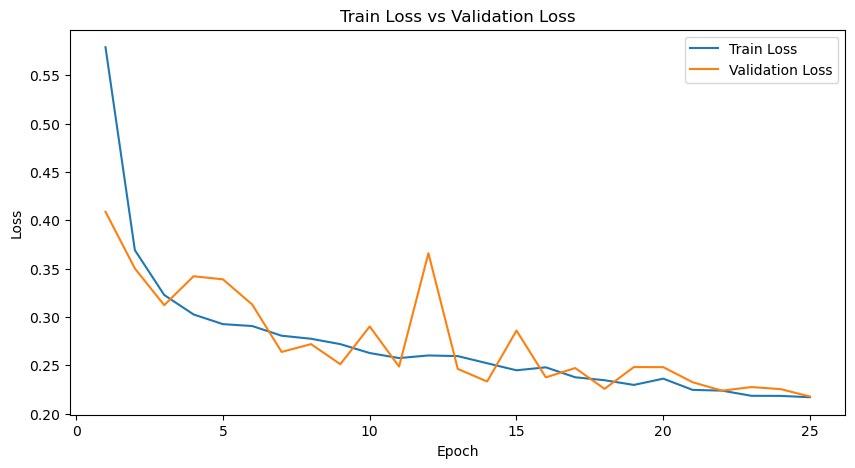

In [8]:
plot_losses(epochs_used, train_losses, val_losses)